# **Afternoon practical day 1** <br>
Welcome to the afternoon practical. Here, you're going to write a function to use cross-validation rather than training on all data. After that, you'll implement multivariate linear regression with linear algebra using numpy. Finally, you'll run it on a small dataset of SNPs, thereby performing an elementary GWAS analysis.

In [1]:
#run this cell to set things up
import GEOparse, ipywidgets as widgets, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display, Markdown
from sklearn.decomposition import PCA
import random as rand
%matplotlib notebook

In [2]:
#necessary functions you defined before:
def univariateHypothesis(x, thetas):
    predict = thetas[0] + thetas[1] * x
    return predict

def multiHypothesis(x, thetas):
    #add a 0 to x as the first 'feature'
    x = pd.Series(1).append(x)
    if not len(x) == len(thetas):
        print("Error, x and theta should have equal length!")
        return
    prediction = sum([x.iloc[index] * thetas[index] for index, _ in enumerate(x)])
    return prediction

def MyMSE(dataframe, thetas, hypothesis = "multiHypothesis"):
    totalSumSquares = 0
    for index, rowData in dataframe.iterrows():
        prediction = globals()[hypothesis](rowData.drop("y"), thetas)
        squareError = (prediction-rowData["y"])**2
        totalSumSquares += squareError
    meanSquaredError = totalSumSquares/len(dataframe) 
    return meanSquaredError

def gradientDescent(dataframe, thetas, alpha, hypothesis = "multiHypothesis"):
    m = len(dataframe)
    #print("m: "); print(m)
    totalErrorThetaZero = 0
    totalErrorOtherThetas = [0] * (len(thetas)-1)
    for index, row in dataframe.iterrows():
        #needed for all thetas, calculate the prediction only once.
        hypothesisOutcome = globals()[hypothesis](row.drop("y"), thetas)
        #calculate partial derivative theta zero.
        errorThetaZero = hypothesisOutcome - row["y"]
        totalErrorThetaZero += errorThetaZero
        #theta zero partial derivative calculated. Now loop over all remaining thetas:
        for otherThetasIndex in range(1,len(thetas)):
            errorThisTheta  = (hypothesisOutcome - row["y"]) * row[otherThetasIndex]
            totalErrorOtherThetas[otherThetasIndex-1] += errorThisTheta
    
    
    #now take a step for every theta
    finalThetas = []
    partialDerivativesAllThetas = totalErrorOtherThetas
    partialDerivativesAllThetas.insert(0, totalErrorThetaZero)
    #loop over all thetas, subtracting alpha/m * its partial derivative from what was put into the function.
    for index, theta in enumerate(partialDerivativesAllThetas):
        finalThetas.append(thetas[index] - alpha/m * partialDerivativesAllThetas[index])
    
    return np.array(finalThetas)

def makePolynomialFeatures(x = pd.DataFrame(None), power = 2):
    
    columns = []
    nameList = []
    for i in range(1, power+1):
        columns.append(x**i)
    finalFeaturesDataFrame = pd.concat(columns, axis = 1)
    columnNames = [name + "toPower" + str(power) for name, power in zip(finalFeaturesDataFrame.columns, list(range(1,power+1)))]
    finalFeaturesDataFrame.columns = columnNames
    return finalFeaturesDataFrame

def createNormalisedFeatures(dataFrame, mode = "range"):
    featureMeans = dataFrame.mean()
    if mode == "range":
        featureRanges = dataFrame.max() - dataFrame.min()
        normalisedFeatures = (dataFrame - featureMeans)/featureRanges
        return [normalisedFeatures, featureMeans, featureRanges]
    elif mode == "SD":
        featureSDs = dataFrame.std()
        normalisedFeatures = (dataFrame - featureMeans)/featureSDs
        return [normalisedFeatures, featureMeans, featureSDs]


#sample data for use
data = pd.read_csv("sampleDataLinearRegression.csv", header= None)
data.columns = ["x", "y"]

featuresHP = makePolynomialFeatures(data["x"], power = 2)

normalisedFeaturesHP, featureMeansHP, featureRangesHP = createNormalisedFeatures(featuresHP, mode = "range")
normalisedFeaturesHP["y"] = data["y"]

# Making a function that splits your training data into k folds for cross-validation

Before, we left off at a point where we could run multivariate  linear regression, in this case on polynomial features. However, we were still fitting to all the data, and are thereby not guarding ourselves against overfitting. What we need is cross-validation: splitting the dataset in k folds, training on k-1 parts of the dataset, then testing on the k-th part, for as many times as you have k. This is called k-fold cross-validation. A number of 10 is often used (10-fold cross-validation), although that's not because it is universally optimal. See here: https://stats.stackexchange.com/a/357749 and here: https://stats.stackexchange.com/a/264721 for more info. It comes down to the bias-variance trade-off that you have heard about. <br> For now, let's set that discussion aside, and focus on making a function `makeCrossValData` that can take our data and create k folds from it for cross-validation.

So, what we want it to use as input and give as output: 
* It takes in a dataFrame with samples on the rows and features in the columns, and a parameter k
* It should return two lists of length k. One list (trainSet) contains the row indices for the training data for a certain fold, the other contains the row indices of the test data for a certain fold. This means that these lists are lists of lists: `trainSet[0]` should return something like `[3, 9, 14, 15, 20, 34]`, which are all the indices of the training samples to train on for the first cross-validation fold. It should also return the shuffled dataFrame. <br> <br>

What we want it to do:
* It first shuffles the data (use `DataFrame.sample(frac=1)` for this).
* It then makes k splits of the data. Note: you probably can't split the data exactly equally. Hence, use something like `int(np.floor(m/k))` , where m = # of samples, to determine the size of the equal splits you can make. And/Or use the modulo operator (`%`) to see the remainder after division by k (i.e. `9 % 4` = 1, because 2\*4 = 8, and then 1 is left).
* Make sure to identify the samples that remain because they can't be divided equally among the folds, and assign them to random folds.

Hints:
* You can make a function return three objects by simply separating them with comma's: `return dataFrame, trainSet, testSet`. Then, when using the function, you should do `shuffledDataFrame, trainSetOutput, testSetOutput = makeCrossValData()`.
* This is somewhat difficult, requiring a bit of looping and checking to make sure that you first make proper-sized folds, then adding the remaining samples to random folds, and then outputting a correct list. If you have difficulties, first use DuckDuckGo (or Google), ask a question, or refer to the answers.
* If you need it: `[item for sublist in listWithSublists for item in sublist]` will take a list that looks like this: `[[25, 12, 3], [18, 33, 21], [1, 13, 5]]` and turn it into `[25, 12, 3, 18, 33, 21, 1, 13, 5]`. This is called a [list comprehension](https://www.datacamp.com/community/tutorials/python-list-comprehension) and is very powerful (but can also be somewhat unclear, and remember that one of the main purposes of code should be to be intelligible to humans that have to read and/or maintain it!).

In [3]:

#answer
def makeCrossValData(dataFrame, k=10):
    '''function to make splits into training and validation sets.
    Outputs two lists of length k, where each element is the indices of samples to train on for that fold, 
    and the indices of samples to test on for that fold, respectively.'''
    #shuffle data
    dataFrame = dataFrame.sample(frac=1)
    m = len(dataFrame)
    #see how many equal-sized sets you can make
    dataPerSplit = int(np.floor(m/k))
    dataPartitions = []
    counter = 0

    for i in range(0,k):
        #make a list of all the samples for each fold
        dataPartitions.append(list(range(counter,counter+dataPerSplit)))
        counter += dataPerSplit

    samplesEquallySplit = k * dataPerSplit
    if not samplesEquallySplit == m:
        #after making equal splits there will be samples left, i.e. you cannot always make k exactly evenly sized subsets.
        #randomly assign left over samples to folds after
        toDivide = m-samplesEquallySplit
        for extraSampleIndex in range(counter, counter+toDivide):
            #only assign to lists of samples that have the current minimum amount of samples
            currentSubsetSizes = np.array([len(subset) for subset in dataPartitions])
            assignTo = np.random.choice(np.where(currentSubsetSizes == np.min(currentSubsetSizes))[0])
            dataPartitions[assignTo].append(extraSampleIndex)
    
    #Now make the final cross-validation set: make k sets, each set has (k-1)/k folds to train on, and 1 fold to test on.
    testSet = []
    trainSet = []
    for validationSetIndex in range(0,k):
        #put 1 fold in the test set
        testSet.append(dataPartitions[validationSetIndex])
        #put all other folds in the train set
        trainSet.append(dataPartitions.copy())
        trainSet[validationSetIndex].pop(validationSetIndex)
        #this line makes sure all training set indices are in one big list, rather than k-1 small lists. 
        trainSet[validationSetIndex] = [item for sublist in trainSet[validationSetIndex] for item in sublist]
    
    return dataFrame, trainSet, testSet
   

# Using the cross-validation function
Now, let's use your cross-validation function to train a multivariate linear regression on the polynomial training data we have been using all along.

List of training set indices to use: 

[[2, 3, 18, 4, 5, 6, 7, 19, 8, 9, 10, 11, 12, 13, 14, 15, 20, 16, 17], [0, 1, 4, 5, 6, 7, 19, 8, 9, 10, 11, 12, 13, 14, 15, 20, 16, 17], [0, 1, 2, 3, 18, 6, 7, 19, 8, 9, 10, 11, 12, 13, 14, 15, 20, 16, 17], [0, 1, 2, 3, 18, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 20, 16, 17], [0, 1, 2, 3, 18, 4, 5, 6, 7, 19, 10, 11, 12, 13, 14, 15, 20, 16, 17], [0, 1, 2, 3, 18, 4, 5, 6, 7, 19, 8, 9, 12, 13, 14, 15, 20, 16, 17], [0, 1, 2, 3, 18, 4, 5, 6, 7, 19, 8, 9, 10, 11, 14, 15, 20, 16, 17], [0, 1, 2, 3, 18, 4, 5, 6, 7, 19, 8, 9, 10, 11, 12, 13, 16, 17], [0, 1, 2, 3, 18, 4, 5, 6, 7, 19, 8, 9, 10, 11, 12, 13, 14, 15, 20]]
--------
List of test set indices to use: 

[[0, 1], [2, 3, 18], [4, 5], [6, 7, 19], [8, 9], [10, 11], [12, 13], [14, 15, 20], [16, 17]]


<IPython.core.display.Javascript object>


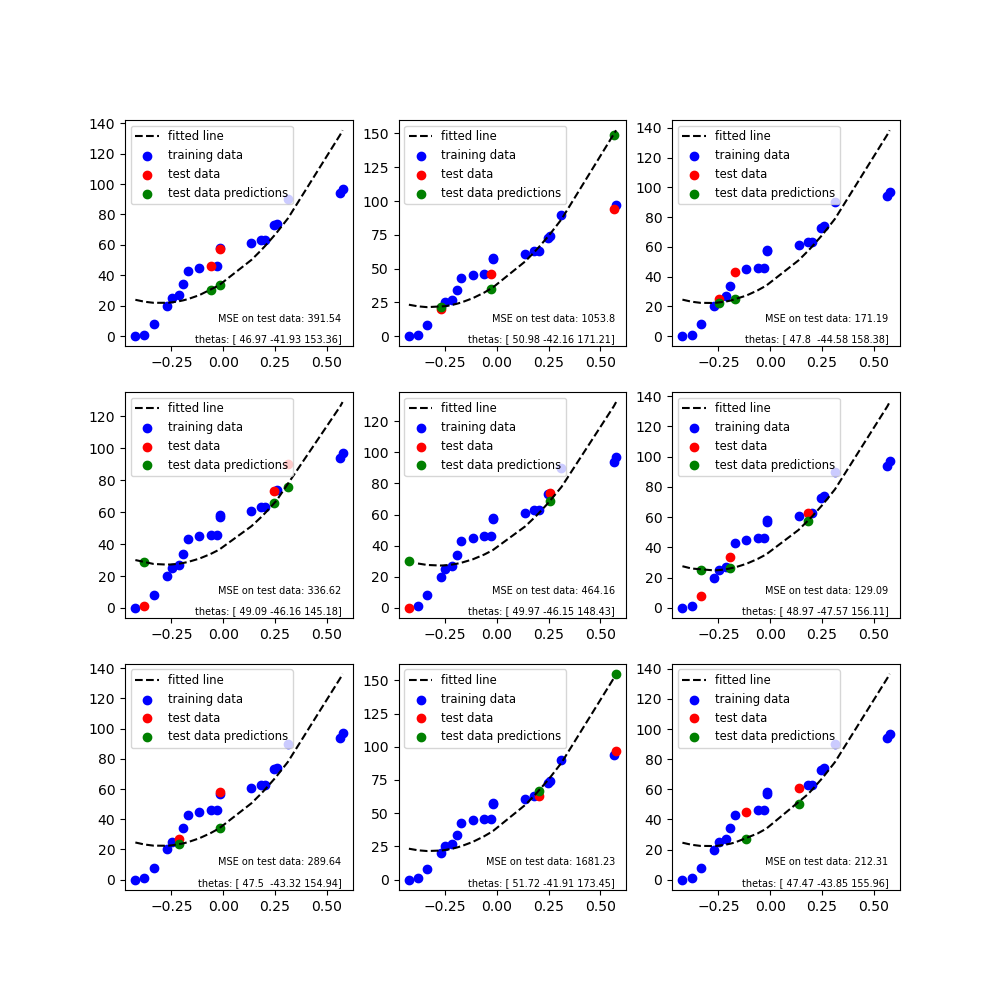

Average test set error: 525.51


In [4]:
#Run your function
shuffledDataFrame, trainSetIndices, testSetIndices = makeCrossValData(normalisedFeaturesHP, 9)

print("List of training set indices to use: \n")
print(trainSetIndices)
print("--------")
print("List of test set indices to use: \n")
print(testSetIndices)

#make a figure to show this
stepsGradDescent = 40
#note: this alpha actually results in rising MSE values after a number of gradient descent steps. In a real scenario,
#I would recommend an alpha of 0.01 to start
alpha = 0.2 
startThetas = [0,0,0]

#lists to store information for all cross-validations:
thetaValuesDuringDescent = []
MSEDuringDescent = []
testMSE = []

figCrossVal, axsCrossVal = plt.subplots(nrows = 3, ncols = 3, figsize = (10,10))


for i in range (0,9):
    trainSubset = shuffledDataFrame.iloc[trainSetIndices[i],:]
    testSubset  = shuffledDataFrame.iloc[testSetIndices[i],:]
    thetaValuesDuringDescent.append([])
    MSEDuringDescent.append([])
    thetasNow = startThetas.copy()
    
    for steps in range(0,stepsGradDescent):
        oneStep = gradientDescent(trainSubset, thetasNow, alpha)
        thetaValuesDuringDescent[-1].append(oneStep)
        thetasNow = oneStep
        MSEDuringDescent[-1].append(MyMSE(trainSubset, thetasNow, hypothesis = 'multiHypothesis'))
    
    #with final thetas, test on the validation set and check MSE
    testMSE.append(MyMSE(testSubset, thetasNow, hypothesis = 'multiHypothesis'))
    

#now plot this data
counterPlotting = 0
for plotY in range(0,3):
    for plotX in range(0,3):

        #print(counterPlotting)
        axsCrossVal[plotX, plotY].scatter(shuffledDataFrame.iloc[trainSetIndices[counterPlotting],0],
                           shuffledDataFrame.iloc[trainSetIndices[counterPlotting],-1],
                           color = "blue", label = "training data")
        axsCrossVal[plotX, plotY].scatter(shuffledDataFrame.iloc[testSetIndices[counterPlotting],0],
                           shuffledDataFrame.iloc[testSetIndices[counterPlotting],-1],
                           color = "red", label = "test data")
        
        #plot predicted test data
        axsCrossVal[plotX, plotY].scatter(shuffledDataFrame.iloc[testSetIndices[counterPlotting],0],
                           [multiHypothesis(row, thetaValuesDuringDescent[counterPlotting][-1]) for index, row in shuffledDataFrame.iloc[testSetIndices[counterPlotting],:].drop("y", axis = 1).iterrows()],
                           color = "green", label = "test data predictions")
        
        #plot all data as predicted by these thetas
        xValuesToPlotHere      = shuffledDataFrame.iloc[trainSetIndices[counterPlotting],0]
        fittedValuesToPlotHere = [multiHypothesis(row, thetaValuesDuringDescent[counterPlotting][-1]) for index, row in shuffledDataFrame.iloc[trainSetIndices[counterPlotting],:].drop("y", axis = 1).iterrows()]
        zippedTogether         = list(zip(xValuesToPlotHere, fittedValuesToPlotHere))
        sortedZipped           = sorted(zippedTogether, key = lambda x : x[0])
        unzippedXAndFitted     = list(zip(*sortedZipped))
        xValuesToPlotHere      = unzippedXAndFitted[0]
        fittedValuesToPlotHere = unzippedXAndFitted[1]
        axsCrossVal[plotX, plotY].plot(xValuesToPlotHere, fittedValuesToPlotHere,
                    color = "black", label = "fitted line", linestyle = 'dashed')
        
        axsCrossVal[plotX, plotY].legend(fontsize = "small")
        
        #add theta values for this cross-validation
        stringToAdd = 'thetas: ' + str(np.round(thetaValuesDuringDescent[counterPlotting][-1], 2))
        axsCrossVal[plotX, plotY].text(0.95, 0.01, stringToAdd ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axsCrossVal[plotX, plotY].transAxes,
        color='black', fontsize=7)
        
        #add mean-squared error on the test set
        stringToAdd = 'MSE on test data: ' + str(np.round(testMSE[counterPlotting], 2))
        axsCrossVal[plotX, plotY].text(0.95, 0.10, stringToAdd ,
        verticalalignment='bottom', horizontalalignment='right',
        transform=axsCrossVal[plotX, plotY].transAxes,
        color='black', fontsize=7)
        counterPlotting += 1
        
        
print("Average test set error: " + str(np.round(np.mean(testMSE), 2)))

# Cross-validated polynomial fitting outcome

Unsurprisingly, you'll see that the prediction performance is abysmal, and also varies a lot per cross-validation. This is because the polynomial function actually doesn't fit the data as it is linear, and there is extremely little data. Hence, it matters a lot which data points are in the test set and which aren't. <br>
Still, it's a good illustration of the power of cross-validation: by seperating our data and training on subsets, we can get a better idea of the generalisation performance, i.e. how well our model will perform on real-world data. If we'd have had a good model rather than a toy one, we could now decide to train the final model on **all** training data, and then publish it and put it to use. <br>


# Linear algebra exercises

Until now, you've been working with for loops and lists, looping over the theta values and corresponding features, multiplying them, then summing these and thereby obtaining the final predictions. For gradient descent, too, we have been working with iteration. As you've been told in the lectures, the language of machine learning is linear algebra. We're now going to focus on implementing what you've done so far in linear algebra. Before we move on, if you're still a little bit unsure about some of what we've done until now, please watch some of the videos given in the course reader, for example on linear regression, the bias-variance trade-off, or cross-validation.

Let's get a bit of a feel for working with matrices. To do that, we'll do some pen-and-paper exercises:
* Go [here](https://www.algebrapracticeproblems.com/matrix-multiplication-product-multiplying-matrices/), read the text and do the first 3 practice problems. You can check your solutions on the site. Be sure to read through the procedures and properties of matrix multiplication so you're sure about your understanding.
* After that's done, do the 3 problems below: <br> <br> <br>

1. $$\begin{bmatrix} 6 & -2 & 5 \\ 1 & 6 & 2 \\ -3 & 4 & 7 \end{bmatrix} \cdot \begin{bmatrix} -4 \\ 8 \\ 3 \end{bmatrix}$$ <br>
2. $$\begin{bmatrix} 2 & -6 & 11 \end{bmatrix} \cdot \begin{bmatrix} -16 \\ -5 \\ 2 \end{bmatrix}$$ <br>
3. $$\begin{bmatrix} 2 & -6 & 11 \end{bmatrix} \cdot \begin{bmatrix} 2 \\ -6 \\ 11 \end{bmatrix}$$

<br> <br> <br> <br> 


Note that problem 3 is the same as summing the element-wise squares of the vector entries. In other words: squaring vector elements and summing them is equal to $V^t*V$

# Checking your answers with numpy

Instead of supplying answers for the above, how's about you check it yourself using numpy? Use the following commands:

* `np.array([[6, 12, 3], [4, 5, 6]])` will result in $\begin{bmatrix} 6 & 12 & 3 \\ 4 & 5 & 6 \end{bmatrix}$
* `A = np.array([[6, 12, 3], [4, 5, 6]])` <br>`B = np.array([[3, 4], [-2, 8], [8, 9]])` <br> `A @ B` <br> 
will result in $\begin{bmatrix} 6 & 12 & 3 \\ 4 & 5 & 6 \end{bmatrix} \cdot \begin{bmatrix} 3 & 4 \\ -2 & 8 \\ 8 & 9 \end{bmatrix} = \begin{bmatrix} 18 & 147 \\ 50 & 110 \end{bmatrix}$ <br>
* `A.transpose()` or `A.T` will yield $\begin{bmatrix} 6 & 4 \\ 12 & 5 \\ 3 & 6 \end{bmatrix}$ (useful for the 3rd problem so you don't repeat yourself)

Check your answers for the three final questions above using these commands in the code cell below.



In [5]:
#answers
#1. 
A = np.array([[6, -2, 5], [1, 6, 2], [-3, 4, 7]])
B = np.array([[-4], [8], [3]])
ans1 = A@B
print(f'Answer 1 : \n {ans1} \n')

#2.
C = np.array([2, -6, 11])
D = np.array([-16, -5, 2])
ans2 = C@D
print(f'Answer 2 : \n {ans2} \n')

#3
ans3 = C.T @ C
print(f'Answer 3 : \n {ans3} \n')

Answer 1 : 
 [[-25]
 [ 50]
 [ 65]] 

Answer 2 : 
 20 

Answer 3 : 
 161 



# Rewriting the univariate and multivariate regression function with linear algebra

In the code cell below, you've been given working examples of the regression hypothesis functions you've been working with. Your job is to make just one function `linAlgRegHypothesis(data, thetas)` that can perform linear regression for any number of features, using linear algebra . To do this, remember the following:
* You can just prepend 1 to a feature vector to make the multiplication of a theta-vector with those features incredibly straightforward.
* You don't need to loop: you can just calculate all predicted values at once using matrix-vector multiplication.
* Use `np.array(normalisedFeaturesHP.loc[:, ["xtoPower1", "xtoPower2"]])` for testing. You'll probably have to use the transpose function.
* To add a column of ones to a feature matrix, use `np.c_[arrayOfOnes, featureArrayOrMatrix]` They should of course have the same length (number of rows).

If you have trouble grappling with numpy, read [this](https://numpy.org/doc/stable/user/absolute_beginners.html) and use [the numpy documentation](https://numpy.org/doc/stable/reference/index.html).

In [6]:
def univariateHypothesis(x, thetas):
    predict = thetas[0] + thetas[1] * x
    return predict

def multiHypothesis(x, thetas):
    #add a 1 to x as the first 'feature'
    x = pd.Series(1).append(x)
    if not len(x) == len(thetas):
        print("Error, x and theta should have equal length!")
        return
    prediction = sum([x.iloc[index] * thetas[index] for index, _ in enumerate(x)])
    return prediction


#answer
def linAlgRegHypothesis(data, thetas):
    #print(thetas)
    data = np.array(data)
    oneFeatToAdd = np.ones(len(data))
    newFeatArray = np.c_[oneFeatToAdd, data]
    predictions = newFeatArray @ thetas
    return predictions

Let's compare the two functions for a given theta vector

In [7]:
thetas        = np.array([12, 3, 5])
data          = np.array(normalisedFeaturesHP.loc[:, ["xtoPower1", "xtoPower2"]])
dataFrame     = normalisedFeaturesHP.loc[:, ["xtoPower1", "xtoPower2"]]
oldFuncOutput = np.array([multiHypothesis(row, thetas) for index, row in dataFrame.iterrows()])
newFuncOutput = linAlgRegHypothesis(data, thetas)

print("Old output: \n")
print(str(oldFuncOutput) + "\n")
print("New output: \n")
print(str(newFuncOutput))

Old output: 

[ 9.39761492  9.54799086  9.7168746  10.00490237 10.11016552 10.2767358
 10.39356633 10.51502382 10.83891046 11.19171555 11.41727946 11.49478091
 11.49478091 12.70125864 13.08760913 13.28772481 13.70183701 13.80825691
 14.35770746 17.25764962 17.39761492]

New output: 

[ 9.39761492  9.54799086  9.7168746  10.00490237 10.11016552 10.2767358
 10.39356633 10.51502382 10.83891046 11.19171555 11.41727946 11.49478091
 11.49478091 12.70125864 13.08760913 13.28772481 13.70183701 13.80825691
 14.35770746 17.25764962 17.39761492]


# Making a mean-squared error function and gradient descent with linear algebra

Now that you've performed this feat for the hypothesis function, let's do the same for the myMSE function and gradient descent. Start with the Mean-Squared error function. There's one additional change: until now we've kept our true values in the data as a column. You might have noticed that we've been working around this. Let's change that, and make sure the true values are vector `y` with n entries, and the data is a matrix with all the features in it.

So:

* rewrite the `myMSE` function (call it `linAlgMSE`) to use linear algebra to immediately calculate the MSE for all samples given the current thetas (rather than looping over them). Give it an extra argument `y` which accepts the true values. Also make it use the new `linAlgRegHypothesis` function you defined above!
* Note: 
* Test that it works using the data provided in the cell below. 

Hints:

* You don't need the call to globals anymore: the `linAlgRegHypothesis` function works for any regression (univariate or multivariate) so you can just use that without giving it as an argument.
* Make sure that the shape of the predictions made with `linAlgRegHypothesis` and of `y` are the same when subtracting. i.e. make them both row-vectors or column-vectors. To make the predictions a column vector, use `np.reshape(predictions, (len(predictions), 1)`.

In [8]:
#data to use for testing
dataMatrix = data
trueValues = np.array(normalisedFeaturesHP.loc[:, ["y"]])
thetas = np.array([50, -48, 155])
print(dataMatrix[0:3, :])
print(trueValues[0:3])

#old function
def MyMSE(dataframe, thetas, hypothesis = "multiHypothesis"):
    totalSumSquares = 0
    for index, rowData in dataframe.iterrows():
        prediction = globals()[hypothesis](rowData.drop("y"), thetas)
        squareError = (prediction-rowData["y"])**2
        totalSumSquares += squareError
    meanSquaredError = totalSumSquares/len(dataframe) 
    return meanSquaredError

#your answer here

#answer
def linAlgMSE(x, y, thetas):
    predictions     = linAlgRegHypothesis(x, thetas)
    predictions     = np.reshape(predictions, (len(predictions), 1))
    ySubtractedPred = predictions - y
    #print((predictions-y).T @ (predictions-y) * (1/len(predictions)))
    meanSquareDifferences = ySubtractedPred.T @ ySubtractedPred * (1/len(predictions))
    return meanSquareDifferences

testOutcomeMSE = linAlgMSE(dataMatrix, trueValues, thetas)
print(testOutcomeMSE)
    

[[-0.42386185 -0.26615991]
 [-0.37990581 -0.26245834]
 [-0.33594976 -0.25505522]]
[[0]
 [1]
 [8]]
[[326.94548061]]


### Comparison with old myMSE
Let's compare your outcomes with the old way of doing things. Run the cell below to see the results.

In [9]:
oldMSEResults = MyMSE(normalisedFeaturesHP, thetas)
newMSEResults = linAlgMSE(dataMatrix, trueValues, thetas)
print("Old function result: ")
print(str(oldMSEResults) + "\n")
print("New function result: ")
print(newMSEResults)

Old function result: 
326.94548061181655

New function result: 
[[326.94548061]]


## Moving on to gradient descent

Now do the same thing for gradient descent. Call the function `linAlgGradientDescent`. You can use [this link](https://medium.com/analytics-vidhya/vectorized-implementation-of-gradient-descent-in-linear-regression-12a10ea37210) if you want to get a bit more insight. The basic things to realise are:

* If you add 1 as the first feature (as in calculation of the predictions), then the partial derivative for the intercept will automatically just be multiplied by 1.
* You can calculate the predictions with the new `linAlgRegHypothesis` you made.
* Watch out that your arrays are the same shape and in the correct column form. To get a column array from a normal (1D) numpy array, use `oneDArray[:, np.newaxis]`. To check array shapes, use `.shape`. If used on a 1D array like `np.array([15, 20, 30]).shape`, it will return `(3,)`. If used on a 2D column vector array like `np.array([[1],[5],[18]]).shape` it will return `(3,1)`. See the example below. You can also use the `.ndim` attribute. If it is 1, it is a 1D array, if 2 a 2D array, etc.


In [66]:
def gradientDescent(dataframe, thetas, alpha, hypothesis = "multiHypothesis"):
    m = len(dataframe)
    #print("m: "); print(m)
    totalErrorThetaZero = 0
    totalErrorOtherThetas = [0] * (len(thetas)-1)
    for index, row in dataframe.iterrows():
        #needed for all thetas, calculate the prediction only once.
        hypothesisOutcome = globals()[hypothesis](row.drop("y"), thetas)
        #calculate partial derivative theta zero.
        errorThetaZero = hypothesisOutcome - row["y"]
        totalErrorThetaZero += errorThetaZero
        #theta zero partial derivative calculated. Now loop over all remaining thetas:
        for otherThetasIndex in range(1,len(thetas)):
            errorThisTheta  = (hypothesisOutcome - row["y"]) * row[otherThetasIndex]
            totalErrorOtherThetas[otherThetasIndex-1] += errorThisTheta
            
    #now take a step for every theta
    finalThetas = []
    partialDerivativesAllThetas = totalErrorOtherThetas
    partialDerivativesAllThetas.insert(0, totalErrorThetaZero)
    #loop over all thetas, subtracting alpha/m * its partial derivative from what was put into the function.
    for index, theta in enumerate(partialDerivativesAllThetas):
        finalThetas.append(thetas[index] - alpha/m * partialDerivativesAllThetas[index])
    
    return np.array(finalThetas)

#numpy example shape
aOneDArray = np.array([15, 20, 30])
print("1D Array: \n")
print(aOneDArray)
print("Its shape attribute: \n")
print(aOneDArray.shape)
print("---------")
print("2D Array (column vector) \n")
aTwoDArray = np.array([[1],[5],[18]])
print(aTwoDArray)
print("Its shape attribute: \n")
print(aTwoDArray.shape)
print("\n")

#subtracting these leads to a matrix where the first row contains [15,20,30] - 1, the second one [15,20,30] - 5, etc.:
print("Subtracting 2D array from 1D array results in a matrix: \n")
print(aOneDArray - aTwoDArray)
print("\n")
#make a 1D array into a 2D array with 1 column and len(1DArray) rows:
print("You can transform the 1D array into a 2D one using reshape: \n")
columnVectorOneDArray = np.reshape(aOneDArray, (len(aOneDArray), 1))
print(columnVectorOneDArray)
print(columnVectorOneDArray.shape)

print("You can also transform a 1D array into a 2D one using np.newaxis: \n")
print(aOneDArray[:, np.newaxis])

#now you can subtract the two column vectors
print("Now you get a simple subtraction to get a new vector: \n")
print(columnVectorOneDArray - aTwoDArray)
print("Number of dimensions: " + str((columnVectorOneDArray - aTwoDArray).ndim))

1D Array: 

[15 20 30]
Its shape attribute: 

(3,)
---------
2D Array (column vector) 

[[ 1]
 [ 5]
 [18]]
Its shape attribute: 

(3, 1)


Subtracting 2D array from 1D array results in a matrix: 

[[14 19 29]
 [10 15 25]
 [-3  2 12]]


You can transform the 1D array into a 2D one using reshape: 

[[15]
 [20]
 [30]]
(3, 1)
You can also transform a 1D array into a 2D one using np.newaxis: 

[[15]
 [20]
 [30]]
Now you get a simple subtraction to get a new vector: 

[[14]
 [15]
 [12]]
Number of dimensions: 2


### Make your new function here:

In [68]:
#answer
def linAlgGradientDescent(x, y, thetas, alpha) :
    m = len(x)
    #print(x)
    #print(y)
    #print(thetas)
    #print(alpha)
    if thetas.ndim != 2:
        thetas = thetas[:, np.newaxis]
    preds  = linAlgRegHypothesis(x, thetas)
    #print(preds)
    #print(thetas)
    if preds.shape != (m, 1):
        #print(np.reshape(preds, m, 1))
        preds  = preds[:, np.newaxis]
    if y.ndim != 2:
        y = y[:, np.newaxis]
    errors = preds - y
    gradientSummation  = errors.T @ np.c_[np.ones(len(errors)), x]
    finalGradientSteps = alpha/m * gradientSummation
    #print(thetas)
    #print(finalGradientSteps)
    newThetas          = thetas - finalGradientSteps.T
    #print(newThetas)
    return newThetas

## Testing your new gradient descent function
Now let's test your new function. Let's use just the x1 feature (i.e. search for optimal parameters for univariate linear regression on the test data set). Note the use of `np.newaxis` to make sure that selecting just one column of the feature array doesn't result in a 1D array. 


<IPython.core.display.Javascript object>


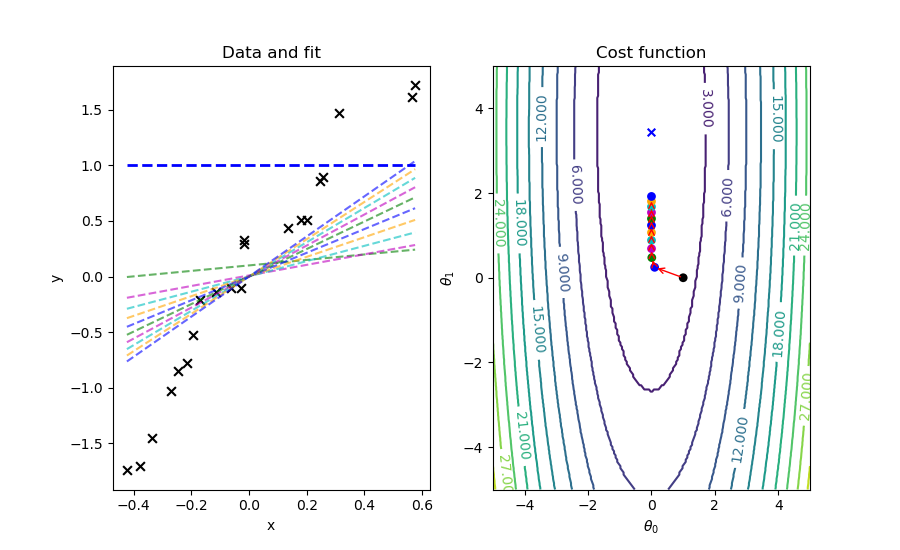

In [12]:
singleFeatData = data[:,0, np.newaxis]
trueValues     = np.array(normalisedFeaturesHP.loc[:, ["y"]])
trueValues     = (trueValues - np.mean(trueValues))/np.std(trueValues)
stepsToTake    = 11
alpha          = 0.9
startThetas    = np.array([[1],[0]])


#Performing gradient descent
thetasDuringDescent       = [startThetas.copy()]
JsGradientDescent         = [linAlgMSE(singleFeatData, trueValues, np.ravel(thetasDuringDescent[-1].T))]
for step in range(0, stepsToTake):
    currentThetas = thetasDuringDescent[-1]
    newThetas     = linAlgGradientDescent(singleFeatData, trueValues, currentThetas, alpha)
    newJ          = linAlgMSE(singleFeatData, trueValues, newThetas)
    
    thetasDuringDescent.append(newThetas)
    JsGradientDescent.append(newJ)


##Plotting shenanigans##

#set up 2 plots
figGradDescent, axGradDescent = plt.subplots(nrows = 1, ncols = 2, figsize=(9,5.5))
#figGradDescent.tight_layout()
#colors for plotting gradient descent steps
colors = ['b', 'g', 'm', 'c', 'orange']

#scatterplot without normalised x values
axGradDescent[0].scatter(singleFeatData, trueValues, marker='x', s=40, color='k')
axGradDescent[0].set_ylabel("y")
axGradDescent[0].set_xlabel("x")

#calculate cost values for many different theta0, theta1 combinations
theta0Vals =  np.linspace(-5, 5, 200)
theta1Vals =  np.linspace(-5, 5, 200)
X, Y = np.meshgrid(theta0Vals, theta1Vals)
JVals = np.zeros(np.shape(X))
for i in range(0,len(theta0Vals)):
    for j in range(0,len(theta1Vals)):
        JVals[i,j] = linAlgMSE(singleFeatData, trueValues, np.array([X[i,j], Y[i,j]]))

#we can reuse the contour plot values we calculated before
contours = axGradDescent[1].contour(X, Y, np.round(JVals,1),
                         levels = 10)
axGradDescent[1].clabel(contours)
axGradDescent[1].set_xlabel(r"$\theta_0$")
axGradDescent[1].set_ylabel(r"$\theta_1$")
minimum = axGradDescent[1].scatter(X[JVals == np.min(JVals)], Y[JVals == np.min(JVals)],
                      color = "blue", label = "minimum", marker = "x",
                      s = 30)

#make the plot of gradient descent steps:

#if stepsToTake > colors, repeat the colors
colors = colors * int(np.ceil(stepsToTake/len(colors)))

#plot initial regression line
axGradDescent[0].plot(singleFeatData, linAlgRegHypothesis(singleFeatData, startThetas),
           color=colors[0], lw=2, linestyle = "dashed",
                        label=r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format(startThetas[0,0], startThetas[1,0])) 

#plot regression lines for each update
for j in range(1,stepsToTake):
    axGradDescent[1].annotate('', xy=np.ravel(thetasDuringDescent[j]), xytext=np.ravel(thetasDuringDescent[j-1]),
                   arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                   va='center', ha='center')
    axGradDescent[0].plot(singleFeatData, linAlgRegHypothesis(singleFeatData, thetasDuringDescent[j]),
               color=colors[j], lw=1.5, alpha = 0.6, linestyle = "dashed",
               label=list(map(r'$\theta_0 = {:.3f}, \theta_1 = {:.3f}$'.format,*thetasDuringDescent[j])))

    
#add points in contour plot for different updated thetas
pointColors = colors.copy()
pointColors.insert(0, "black")
axGradDescent[1].scatter(*zip(*thetasDuringDescent), c=pointColors[0:len(thetasDuringDescent)], s=40, lw=0)

# Labels, titles and a legend.
axGradDescent[1].set_xlabel(r'$\theta_0$')
axGradDescent[1].set_ylabel(r'$\theta_1$')
axGradDescent[1].set_title('Cost function')

axGradDescent[0].set_title('Data and fit')
axbox = axGradDescent[0].get_position()
# Position the legend by hand so that it doesn't cover up any of the lines.
#if not stepsToTake > 10:
#    axGradDescent[0].legend(fontsize='small')

figGradDescent.show()


## Wrap-up and moving on to a GWAS(-like) analysis

Hopefully, it's a success! If not, be sure to check the shape of your arrays with `.shape` and `.ndim`, and try to figure out what inputs are going awry. <br> <br> <br> Now let's move on to some (very limited) GWAS analysis, based on data from [here](https://github.com/MareesAT/GWA_tutorial/). Below, we load in some example data and explore it. Before this can be done, do the following:

* open an Anaconda prompt, activate the environment you use for the course (if using), and type `conda install -c conda-forge pandas-plink`

In [13]:
from pandas_plink import read_plink1_bin
euroGWASData = read_plink1_bin("HapMap_3_r3_1.bed", "HapMap_3_r3_1.bim", "HapMap_3_r3_1.fam", verbose=True)
print(euroGWASData)
print(euroGWASData.sel(sample = "NA06989"))
print(euroGWASData.sel(sample = "NA06989").values)

Mapping files: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


<xarray.DataArray 'genotype' (sample: 165, variant: 1457897)>
dask.array<transpose, shape=(165, 1457897), dtype=float32, chunksize=(165, 1024), chunktype=numpy.ndarray>
Coordinates:
  * sample   (sample) object 'NA06989' 'NA11891' ... 'NA10854' 'NA12865'
  * variant  (variant) <U14 'variant0' 'variant1' ... 'variant1457896'
    fid      (sample) object '1328' '1377' '1349' ... '1375' '1349' '1459'
    iid      (sample) object 'NA06989' 'NA11891' ... 'NA10854' 'NA12865'
    father   (sample) object '0' '0' '0' '0' ... '0' '0' 'NA11839' 'NA12874'
    mother   (sample) object '0' '0' '0' '0' ... '0' '0' 'NA11840' 'NA12875'
    gender   (sample) object '2' '1' '1' '2' '1' '2' ... '2' '1' '1' '1' '2' '2'
    trait    (sample) object '2' '2' '1' '2' '-9' ... '-9' '2' '1' '-9' '-9'
    chrom    (variant) object '1' '1' '1' '1' '1' ... '25' '25' '25' '25' '25'
    snp      (variant) object 'rs2185539' 'rs11510103' ... 'rs1973881'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0

## Questions about the GWAS dataset
The print-out of this data is rather complicated. That's because it is a read-in of binary datafiles in PLINK format, a command-line programme that is often used for GWAS analysis. The data is saved in an xarray, which is a specialised datatype that we won't go into here. Note that the rows have samples, and the columns contain features (here: 0, 1 or 2 for a certain SNP). Do the following:

* Go [here](https://pandas-plink.readthedocs.io/en/latest/usage.html) and read the entry under Genotype (ignore the Kinship matrix part). After that, read [this](https://pandas-plink.readthedocs.io/en/latest/api/pandas_plink.read_plink1_bin.html)

Answer these questions:

1. How many SNPs are in this data?
2. How many SNPs are on chromosome 11?
3. How many male genomes are in this dataset? (see [this](https://www.cog-genomics.org/plink/1.9/formats#fam))
4. How many genomes lack gender annotation?

In [14]:
#answer
#1. 1457897
print(len(euroGWASData.sel(sample = "NA06989").values))
#2. 72993
chromElevenData = euroGWASData.where(euroGWASData.chrom == "11", drop = True)
print(chromElevenData.shape[1])
#3. 80/165
maleNumber = euroGWASData.where(euroGWASData.gender == "1", drop = True).shape
print("Number of males: " + str(maleNumber[0]))
#4. None
genderLess = euroGWASData.where(euroGWASData.gender == "0", drop = True).shape
print("No gender known: " + str(genderLess[0]))


1457897
72993
Number of males: 80
No gender known: (


# SNP analysis on chromosome eleven subset.
Let's continue with only SNPs on chromosome eleven, and 'only' 200 SNPs there. That's still plenty of data. As you've been told, a GWAS simply trains a linear model on the #of alles you have for a certain SNP: if A is normal at a location and you have 2* A, you have 0. If you have a T in 1 copy of that gene, you have 1. If you are homozygously different from A (2 Ts), you have a 2. In contrast to more complex algorithms, SNPs are supposed to have additive effects: we simply tally the effect of one SNP on having the outcome measure with all others, and the total would be the expected effect of your genetic make-up on some outcome like BMI. Within SNPs, too, we generally assume an additive model: that having 2 alternative alleles at a SNP location has twice the effect of having 1. In reality, of course, there can be epistasis, or one allele could do nothing but having 2 mutations has a very large effect (All this is simplifying the field of GWAS, of course, there's a _lot_ of nuance we're leaving out for the purpose of brevity).

The cel immediately below makes sure that there is a simulated quantitative outcome measure (BMI), and that a few SNPs on chromosome eleven influence this trait. Your job is to complete the code in the cell below to run linear regressions on those SNPs using your own functions. There is a slight handicap in this approach: the well-known Manhattan plots of GWAS (see below) require p-values for the associations in the linear regressions which are obtained by bootstrapping or other statistical methods. We won't use that here, so we'll have to contend with the estimated coefficients alone: if there's no effect of a SNP on BMI, you'd expect $\theta_1$ in $\theta_0 + \theta_1 \cdot n_{SNPs}$ to be small (i.e. around 0). If there is an effect of the SNP you'd expect it to be large. Note that this is shoddy statistics: a SNP can have a very small effect size (increasing BMI by only 0.001 units) but still reliably do that when measured in a cohort of millions of people. However, the synthetic data I add should have rather large effect sizes.

![Manhattan plots](ManhattanPlot.jpg)

**TE DOEN: maak de trait value kwantitatief zodat je lineaire regressie kan gebruiken (anders moet je logistische regressie doen) <br>
Zie hier voor meer info https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3531285/ <br>
http://faculty.washington.edu/tathornt/SISG2015/lectures/assoc2015session06.pdf ook
en http://faculty.washington.edu/tathornt/SISG2015/lectures/assoc2015session05.pdf 
en http://faculty.washington.edu/tathornt/SISG2015/lectures/assoc2015session02.pdf **



In [226]:
downsizedData = euroGWASData.where(euroGWASData.chrom == "11", drop = True)
downsizedData = downsizedData[:, rand.sample(range(0, downsizedData.shape[1]), 200)]
#remove columns that have all 0, 1 or 2 --> can't infer anything there
columnsWithoutVariation = np.all(downsizedData.values == downsizedData.values[0,:], axis = 0)
downsizedData = downsizedData[:, np.invert(columnsWithoutVariation)]


#sample some SNPs to assign a signal
SNPsForSignal = np.array(rand.sample(range(0, downsizedData.shape[1]), 20))

#add normally distributed BMI value with mean that is somewhat healthy 
newArray = np.zeros(len(downsizedData.trait))
downsizedDataNew = downsizedData.drop_vars("trait")
newArray = np.random.default_rng().normal(22.5, 1, len(newArray))
downsizedDataNew["BMI"] = ("sample", newArray)


#now, give certain SNPs a protective effect for BMI (help in being leaner) and a few the effect of predisposing to high BMI
#assume additivity within the SNP, which is to say: one protective allele has half the protective effect of 2.
protectiveSNPs = np.array(rand.sample(list(SNPsForSignal), 5))
diseaseSNPs    = np.array([i for i in SNPsForSignal if i not in protectiveSNPs])

protectiveEffect = 3
for protSNPCoord in protectiveSNPs:
    twoAlleles  = np.where(downsizedDataNew[:, protSNPCoord].values == 2.)
    oneAllele   = np.where(downsizedDataNew[:, protSNPCoord].values == 1.)
    noMuts      = np.where(downsizedDataNew[:, protSNPCoord].values == 0.)
    newArray[twoAlleles] -= np.random.default_rng().normal(protectiveEffect, 0.1, len(twoAlleles))
    newArray[oneAllele]  -= np.random.default_rng().normal(protectiveEffect/2, 0.1, len(oneAllele))

obesityEffect = 3.87
for disSNPCoord in diseaseSNPs:
    break
    twoAlleles  = np.where(downsizedDataNew[:, disSNPCoord].values == 2.)
    oneAllele   = np.where(downsizedDataNew[:, disSNPCoord].values == 1.)
    noMuts      = np.where(downsizedDataNew[:, disSNPCoord].values == 0.)
    newArray[twoAlleles] += np.random.default_rng().normal(obesityEffect, 0.1, len(twoAlleles))
    newArray[oneAllele]  += np.random.default_rng().normal(obesityEffect/2, 0.1, len(oneAllele))


downsizedData["BMI"] = ("sample", newArray)    


## Doing your analysis
Okay, the data is all set up. There is just one thing: there are missing data in this GWAS dataset: SNPs that were not measured for certain people. For now, we'll just replace these NaNs with 0, assuming they are the most common genotype. In fact, there's two things: the second one is that there are SNPs where every person in the dataset has either 0, 1, or 2: we can't say anything there. I've prefiltered those columns out for you in the code cell above. Now to run the linear regressions as used in GWAS:
* Loop over the columns of the data. Each column contains data for a single SNP. To get at this data, use `downsizedData[:, columnNr].values
* This SNP data is your feature. Run linear regression on this feature, using the BMI as the outcome. Don't forget to add the intercept feature which is just an array of ones (or alternatively, this might be incorporated into your linAlgGradientDescent function already).
* To run linear regression:
    * Make sure you normalise the feature and the BMI.
    * Initialise thetas (done for you).
    * Run gradient descent for a number of steps (nSteps = 10 below)
    * Save the resulting theta values in a list or array, so that you get, per SNP in the data, the two thetas.


In [227]:
#set-up. Set mean BMI as start value for intercept.
startThetas = np.array([[np.mean(newArray)], [0]])
nSteps      = 20
outcome     = downsizedData["BMI"].values
#Normalise the outcome measure!

alpha       = 0.3 
listThetasForEachSNP = []




#up to you: use gradient descent to find the thetas, save these thetas in a list after all nSteps are done.
#don't forget to normalise BMI and the features!
for SNPIndex in range(0, downsizedData.shape[1]):
    #replace np.nan with 0
    values = downsizedData[:, SNPIndex].values
    values[np.isnan(values)] = 0
    
    for step in range(1, nSteps):
        break
    break
        
        
#Answer
outcomeNorm, outcomeMean, outcomeSD = createNormalisedFeatures(outcome, mode = "SD")

for SNPIndex in range(0, downsizedData.shape[1]):
    features = downsizedData[:, SNPIndex].values
    features[np.isnan(features)] = 0
    featuresNorm, mean, SD = createNormalisedFeatures(features, mode= "SD")
    currentThetas = startThetas
    for step in range(1, nSteps):
        #up to you: use gradient descent to find the thetas, save these thetas in a list after all nSteps are done.
        newThetas = linAlgGradientDescent(featuresNorm, outcomeNorm, currentThetas, alpha)
        currentThetas = newThetas
    listThetasForEachSNP.append(currentThetas)




## Checking the regression values you obtained

Now, let's take the 20 largest absolute $\theta_1$ values and see whether these correspond to the signal we put into the BMI values.

In [228]:
listThetasForEachSNP
arrayFittedThetas = np.hstack(listThetasForEachSNP)
dfFittedThetas    = pd.DataFrame(arrayFittedThetas)

#sort it
dfFittedThetas.loc[len(dfFittedThetas.index)] = abs(dfFittedThetas.iloc[1,:])
dfFittedThetas = dfFittedThetas.sort_values(by = 2, axis = 1)

twentyLargestThetaOnes = dfFittedThetas.iloc[:, -20:len(dfFittedThetas.columns)]
sumSignalsDetected = sum(np.in1d(SNPsForSignal, twentyLargestThetaOnes.columns))
print("SNPs with top 20 theta_1 values out of 20 SNPs with signal synthetically added: ")
print(sumSignalsDetected)

SNPs with top 20 theta_1 values out of 20 SNPs with signal synthetically added: 
6


## Plotting the linear regressions for SNPs with large effect sizes

The below plots the linear regression plots for those SNPs that have actual signal.


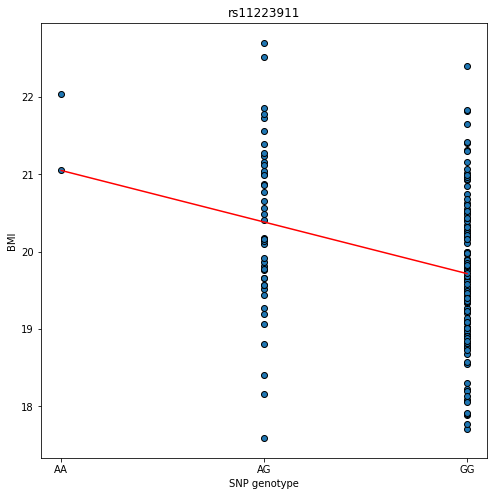

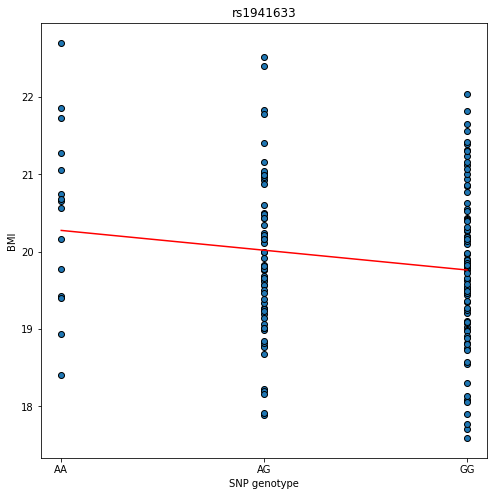

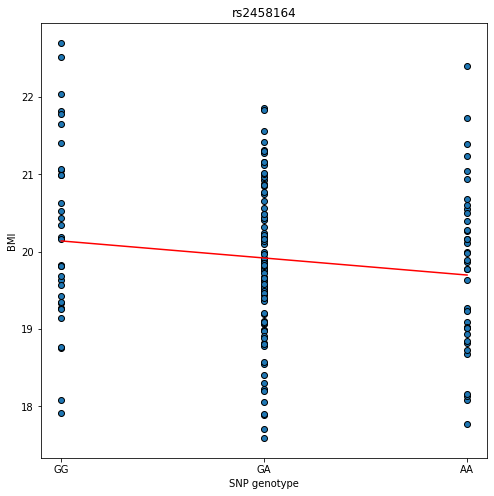

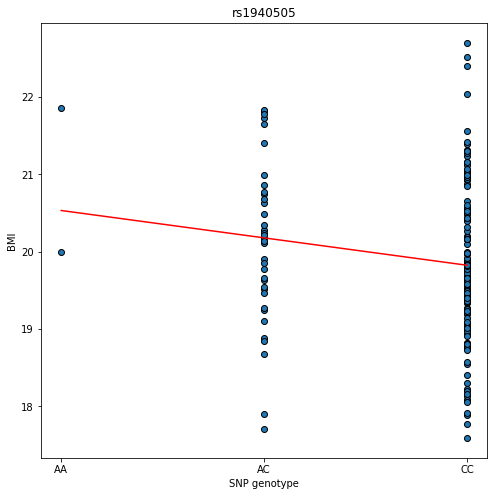

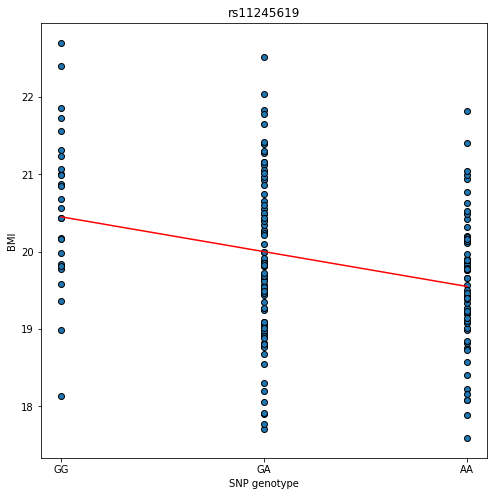

In [257]:
import warnings
%matplotlib inline 

indicesLargestThetaOneActualSignal = SNPsForSignal[np.in1d(SNPsForSignal, twentyLargestThetaOnes.columns)]

outcomeNorm, outcomeMean, outcomeSD = createNormalisedFeatures(outcome, mode = "SD")

neededData = downsizedData[:, indicesLargestThetaOneActualSignal]

for SNPindex, SNPlocation in enumerate(indicesLargestThetaOneActualSignal):
    thetasHere = twentyLargestThetaOnes.iloc[0:2, np.where(twentyLargestThetaOnes.columns == SNPlocation)[0][0]]
    #maybe return to normal coordinates
    features = neededData.values[:, SNPindex]
    features[np.isnan(features)] = 0
    featuresNorm, mean, SD = createNormalisedFeatures(features, mode= "SD")
    SNPsPresentInData = np.in1d(np.array([0., 1.,2.]), features)
    #skip SNPs where not all 3 genotypes are present, complicates plotting considerably
    if not np.all(SNPsPresentInData):
        continue
    normalAllele = neededData["a0"].values[SNPindex]
    alternativeAllele = neededData["a1"].values[SNPindex]
    xLabels = [normalAllele*2, normalAllele+alternativeAllele, alternativeAllele*2]
    xLabels = np.array(xLabels)[np.where(np.in1d(np.array([0., 1.,2.]), features))]
    SNPName = neededData["snp"].values[SNPindex]
    #only predict once for each possible feature value
    uniqueAlleleNr = np.sort(np.unique(featuresNorm))
    predictions = linAlgRegHypothesis(uniqueAlleleNr, thetasHere)
    #print(predictions)
    #print(predictions * SD + mean)
    fig, ax = plt.subplots(figsize = (8,8))
    ax.scatter(featuresNorm, outcomeNorm *outcomeSD + outcomeMean, edgecolors = "black")
    ax.set_xticks(np.unique(featuresNorm))
    ax.set_xlabel("SNP genotype")
    ax.set_xticklabels(xLabels.tolist())
    ax.set_ylabel ("BMI")
    ax.set_title(SNPName)
    ax.plot(uniqueAlleleNr, predictions * outcomeSD + outcomeMean, color = "red")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fig.show()


## The end

Congratulations, you've mastered linear regression using gradient descent and linear algebra, as well as implemented cross-validation! <br> I'd like to stress once more that the 'GWAS' we've done here is a parody of the real thing. There's familial relations to take into account (you share many SNPs with parents and grandparent), sex assignment to check, missing data to impute or otherwise correct for, etc. Nevertheless, the principle of running a linear regression for each SNP is the same. At the end of the week, we'll be able to correct a GWAS for population covariance in SNPs which will already bring us closer to the real deal (here the data was only from European citizens). All that's left is to fill out this short survey about today: **ADD LINK**